In [1]:
import cv2
print("✅ cv2 version:", cv2.__version__)


✅ cv2 version: 4.10.0


In [1]:
import os
import numpy as np
import cv2
from glob import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [2]:
# 設定圖像大小
IMG_SIZE = 256

def load_data(image_dir, mask_dir):
    image_paths = sorted(glob(os.path.join(image_dir, "*.jpg")))
    mask_paths = sorted(glob(os.path.join(mask_dir, "*.png")))

    images = []
    masks = []

    for img_path, mask_path in zip(image_paths, mask_paths):
        # 讀取影像並轉成 RGB
        img = cv2.imread(img_path)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0  # 正規化
        images.append(img)

        # 讀取遮罩
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = mask / 255.0
        mask = np.expand_dims(mask, axis=-1)  # 增加通道維度
        masks.append(mask)

    return np.array(images), np.array(masks)


In [3]:
base_path = "ETT-v3/Fold1"

x_train, y_train = load_data(os.path.join(base_path, "train"), os.path.join(base_path, "trainannot"))
x_val, y_val = load_data(os.path.join(base_path, "val"), os.path.join(base_path, "valannot"))
x_test, y_test = load_data(os.path.join(base_path, "test"), os.path.join(base_path, "testannot"))


In [4]:
def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bridge
    b1 = conv_block(p4, 1024)

    # Decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    # Output
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="U-Net")
    return model


In [5]:
# 建立模型
input_shape = (IMG_SIZE, IMG_SIZE, 3)
model = build_unet(input_shape)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# 設定 callback：提早停止與儲存最佳模型
callbacks = [
    ModelCheckpoint("unet_fold1_best.h5", save_best_only=True, monitor="val_loss"),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

# 開始訓練
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=8,
    epochs=50,
    callbacks=callbacks
)


Epoch 1/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9827 - loss: 0.2341

36/36 ━━━━━━━━━━━━━━━━━━━━ 259s 7s/step - accuracy: 0.9828 - loss: 0.2330 - val_accuracy: 0.9913 - val_loss: 0.5556
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9895 - loss: 0.1264

36/36 ━━━━━━━━━━━━━━━━━━━━ 308s 9s/step - accuracy: 0.9895 - loss: 0.1261 - val_accuracy: 0.9913 - val_loss: 0.4027
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9910 - loss: 0.0876

36/36 ━━━━━━━━━━━━━━━━━━━━ 319s 9s/step - accuracy: 0.9910 - loss: 0.0874 - val_accuracy: 0.9913 - val_loss: 0.2749
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9927 - loss: 0.0688

36/36 ━━━━━━━━━━━━━━━━━━━━ 346s 10s/step - accuracy: 0.9927 - loss: 0.0688 - val_accuracy: 0.9913 - val_loss: 0.1975
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9936 - loss: 0.0553

36/36 ━━━━━━━━━━━━━━━━━━━━ 351s 10s/step - accuracy: 0.9936 - loss: 0.0552 - val_accuracy: 0.9913 - val_loss: 0.1330
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9944 - loss: 0.0468

36/36 ━━━━━━━━━━━━━━━━━━━━ 355s 10s/step - accuracy: 0.9945 - loss: 0.0468 - val_accuracy: 0.9913 - val_loss: 0.0998
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9950 - loss: 0.0418

36/36 ━━━━━━━━━━━━━━━━━━━━ 330s 9s/step - accuracy: 0.9951 - loss: 0.0418 - val_accuracy: 0.9915 - val_loss: 0.0748
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.9958 - loss: 0.0371

36/36 ━━━━━━━━━━━━━━━━━━━━ 346s 10s/step - accuracy: 0.9958 - loss: 0.0371 - val_accuracy: 0.9913 - val_loss: 0.0671
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9959 - loss: 0.0348

36/36 ━━━━━━━━━━━━━━━━━━━━ 300s 8s/step - accuracy: 0.9959 - loss: 0.0348 - val_accuracy: 0.9916 - val_loss: 0.0559
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9958 - loss: 0.0331

36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9958 - loss: 0.0331 - val_accuracy: 0.9917 - val_loss: 0.0515
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9962 - loss: 0.0303

36/36 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step - accuracy: 0.9962 - loss: 0.0303 - val_accuracy: 0.9919 - val_loss: 0.0471
Epoch 12/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9968 - loss: 0.0276

36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9968 - loss: 0.0276 - val_accuracy: 0.9925 - val_loss: 0.0390
Epoch 13/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9970 - loss: 0.0258

36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9970 - loss: 0.0258 - val_accuracy: 0.9925 - val_loss: 0.0381
Epoch 14/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9971 - loss: 0.0246

36/36 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step - accuracy: 0.9971 - loss: 0.0246 - val_accuracy: 0.9922 - val_loss: 0.0358
Epoch 15/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9971 - loss: 0.0233

36/36 ━━━━━━━━━━━━━━━━━━━━ 283s 8s/step - accuracy: 0.9971 - loss: 0.0233 - val_accuracy: 0.9927 - val_loss: 0.0351
Epoch 16/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9974 - loss: 0.0216

36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9974 - loss: 0.0216 - val_accuracy: 0.9928 - val_loss: 0.0327
Epoch 17/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9974 - loss: 0.0208

36/36 ━━━━━━━━━━━━━━━━━━━━ 279s 8s/step - accuracy: 0.9974 - loss: 0.0207 - val_accuracy: 0.9930 - val_loss: 0.0315
Epoch 18/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.9975 - loss: 0.0196 - val_accuracy: 0.9930 - val_loss: 0.0316
Epoch 19/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9976 - loss: 0.0184

36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9976 - loss: 0.0184 - val_accuracy: 0.9933 - val_loss: 0.0287
Epoch 20/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9978 - loss: 0.0174

36/36 ━━━━━━━━━━━━━━━━━━━━ 279s 8s/step - accuracy: 0.9978 - loss: 0.0174 - val_accuracy: 0.9931 - val_loss: 0.0268
Epoch 21/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9979 - loss: 0.0165

36/36 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step - accuracy: 0.9979 - loss: 0.0165 - val_accuracy: 0.9934 - val_loss: 0.0263
Epoch 22/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9978 - loss: 0.0160

36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9978 - loss: 0.0160 - val_accuracy: 0.9932 - val_loss: 0.0263
Epoch 23/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9977 - loss: 0.0155

36/36 ━━━━━━━━━━━━━━━━━━━━ 283s 8s/step - accuracy: 0.9977 - loss: 0.0155 - val_accuracy: 0.9936 - val_loss: 0.0252
Epoch 24/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 287s 8s/step - accuracy: 0.9979 - loss: 0.0147 - val_accuracy: 0.9932 - val_loss: 0.0253
Epoch 25/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9979 - loss: 0.0139

36/36 ━━━━━━━━━━━━━━━━━━━━ 295s 8s/step - accuracy: 0.9979 - loss: 0.0139 - val_accuracy: 0.9932 - val_loss: 0.0243
Epoch 26/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9980 - loss: 0.0131

36/36 ━━━━━━━━━━━━━━━━━━━━ 292s 8s/step - accuracy: 0.9980 - loss: 0.0131 - val_accuracy: 0.9934 - val_loss: 0.0242
Epoch 27/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 290s 8s/step - accuracy: 0.9981 - loss: 0.0125 - val_accuracy: 0.9932 - val_loss: 0.0245
Epoch 28/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9980 - loss: 0.0123

36/36 ━━━━━━━━━━━━━━━━━━━━ 294s 8s/step - accuracy: 0.9980 - loss: 0.0123 - val_accuracy: 0.9934 - val_loss: 0.0235
Epoch 29/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9982 - loss: 0.0114

36/36 ━━━━━━━━━━━━━━━━━━━━ 293s 8s/step - accuracy: 0.9982 - loss: 0.0114 - val_accuracy: 0.9935 - val_loss: 0.0231
Epoch 30/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9981 - loss: 0.0112

36/36 ━━━━━━━━━━━━━━━━━━━━ 296s 8s/step - accuracy: 0.9981 - loss: 0.0112 - val_accuracy: 0.9935 - val_loss: 0.0224
Epoch 31/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.9982 - loss: 0.0105

36/36 ━━━━━━━━━━━━━━━━━━━━ 293s 8s/step - accuracy: 0.9982 - loss: 0.0105 - val_accuracy: 0.9937 - val_loss: 0.0221
Epoch 32/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 292s 8s/step - accuracy: 0.9983 - loss: 0.0101 - val_accuracy: 0.9935 - val_loss: 0.0226
Epoch 33/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 279s 8s/step - accuracy: 0.9982 - loss: 0.0098 - val_accuracy: 0.9935 - val_loss: 0.0223
Epoch 34/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9983 - loss: 0.0094 - val_accuracy: 0.9936 - val_loss: 0.0222
Epoch 35/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9984 - loss: 0.0089

36/36 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.9984 - loss: 0.0089 - val_accuracy: 0.9937 - val_loss: 0.0218
Epoch 36/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 278s 8s/step - accuracy: 0.9984 - loss: 0.0085 - val_accuracy: 0.9936 - val_loss: 0.0223
Epoch 37/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.9984 - loss: 0.0083 - val_accuracy: 0.9934 - val_loss: 0.0218
Epoch 38/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.9983 - loss: 0.0080 - val_accuracy: 0.9934 - val_loss: 0.0224
Epoch 39/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9984 - loss: 0.0077

36/36 ━━━━━━━━━━━━━━━━━━━━ 279s 8s/step - accuracy: 0.9984 - loss: 0.0077 - val_accuracy: 0.9936 - val_loss: 0.0209
Epoch 40/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.9984 - loss: 0.0076 - val_accuracy: 0.9936 - val_loss: 0.0209
Epoch 41/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9984 - loss: 0.0072 - val_accuracy: 0.9934 - val_loss: 0.0222
Epoch 42/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 281s 8s/step - accuracy: 0.9984 - loss: 0.0073 - val_accuracy: 0.9935 - val_loss: 0.0215
Epoch 43/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9985 - loss: 0.0068

36/36 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.9985 - loss: 0.0068 - val_accuracy: 0.9935 - val_loss: 0.0206
Epoch 44/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9985 - loss: 0.0065

36/36 ━━━━━━━━━━━━━━━━━━━━ 278s 8s/step - accuracy: 0.9985 - loss: 0.0065 - val_accuracy: 0.9936 - val_loss: 0.0198
Epoch 45/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 279s 8s/step - accuracy: 0.9985 - loss: 0.0064 - val_accuracy: 0.9935 - val_loss: 0.0209
Epoch 46/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 280s 8s/step - accuracy: 0.9985 - loss: 0.0060 - val_accuracy: 0.9937 - val_loss: 0.0200
Epoch 47/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step - accuracy: 0.9985 - loss: 0.0058 - val_accuracy: 0.9937 - val_loss: 0.0206
Epoch 48/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step - accuracy: 0.9984 - loss: 0.0059 - val_accuracy: 0.9935 - val_loss: 0.0206
Epoch 49/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 282s 8s/step - accuracy: 0.9985 - loss: 0.0056 - val_accuracy: 0.9937 - val_loss: 0.0201


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


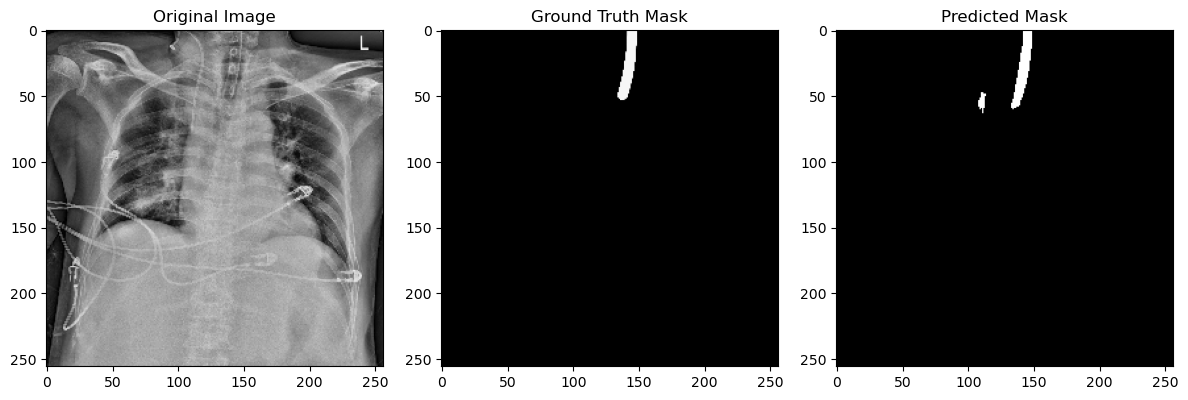

In [6]:
def visualize_prediction(index):
    image = x_test[index]
    true_mask = y_test[index]

    pred_mask = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)  # 二值化處理

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(image)

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(true_mask[..., 0], cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(pred_mask[..., 0], cmap="gray")

    plt.tight_layout()
    plt.show()

# 看第 0 張測試圖的預測結果
visualize_prediction(0)


In [7]:
def calculate_iou(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    iou = intersection / (union + 1e-7)
    return iou

ious = []
for i in range(len(x_test)):
    pred = model.predict(np.expand_dims(x_test[i], axis=0))[0]
    pred = (pred > 0.5).astype(np.uint8)
    iou = calculate_iou(y_test[i], pred)
    ious.append(iou)

mean_iou = np.mean(ious)
print(f"平均 IOU: {mean_iou:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [8]:
def get_endpoint_y(mask):
    coords = np.argwhere(mask[..., 0] > 0.5)
    if len(coords) == 0:
        return None
    return np.max(coords[:, 0])  # y 座標最大值


In [9]:
pixel_per_cm = 72

total_error = []
within_05cm = 0
within_10cm = 0
valid_count = 0

for i in range(len(x_test)):
    true_y = get_endpoint_y(y_test[i])
    pred_mask = model.predict(np.expand_dims(x_test[i], axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    pred_y = get_endpoint_y(pred_mask)

    if true_y is not None and pred_y is not None:
        error_pixel = abs(pred_y - true_y)
        total_error.append(error_pixel / pixel_per_cm)
        valid_count += 1

        if error_pixel <= 36:
            within_05cm += 1
        if error_pixel <= 72:
            within_10cm += 1

if valid_count > 0:
    avg_error_cm = np.mean(total_error)
    acc_05cm = within_05cm / valid_count
    acc_10cm = within_10cm / valid_count

    print(f"平均端點誤差: {avg_error_cm:.2f} 公分")
    print(f"誤差在 0.5 公分內準確率: {acc_05cm:.2%}")
    print(f"誤差在 1.0 公分內準確率: {acc_10cm:.2%}")
else:
    print("沒有有效的預測端點，請檢查 mask")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [11]:
def get_endpoint_coords(mask):
    coords = np.argwhere(mask[..., 0] > 0.5)
    if len(coords) == 0:
        return None
    return coords[np.argmax(coords[:, 0])]  # y 最大的那一點 (y, x)

def plot_with_endpoints(index):
    image = x_test[index].copy()
    true_coord = get_endpoint_coords(y_test[index])

    pred_mask = model.predict(np.expand_dims(x_test[index], axis=0))[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)
    pred_coord = get_endpoint_coords(pred_mask)

    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(image)

    if true_coord is not None:
        ax.plot(true_coord[1], true_coord[0], 'ro', label='Ground Truth')  # (x, y)

    if pred_coord is not None:
        ax.plot(pred_coord[1], pred_coord[0], 'bo', label='Prediction')  # (x, y)

    ax.set_title(f"Endpoint Comparison (index={index})")
    ax.legend()
    plt.show()
    plot_with_endpoints(0)


In [25]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display  # ← 必須放在函式外面

def visualize_with_mask_and_endpoints_inline(index):
    image = x_test[index]
    true_mask = y_test[index]

    pred_mask = model.predict(np.expand_dims(image, axis=0), verbose=0)[0]
    pred_mask = (pred_mask > 0.5).astype(np.uint8)

    true_coord = get_endpoint_coords(true_mask)
    pred_coord = get_endpoint_coords(pred_mask)

    fig = plt.figure(figsize=(12, 4))

    # 原圖
    ax1 = fig.add_subplot(1, 3, 1)
    ax1.imshow(image)
    ax1.set_title("Image")
    ax1.axis("off")

    # 真實遮罩 + G
    ax2 = fig.add_subplot(1, 3, 2)
    ax2.imshow(true_mask[..., 0], cmap='viridis')
    if true_coord is not None:
        ax2.plot(true_coord[1], true_coord[0], 'ro')
        ax2.text(true_coord[1]+2, true_coord[0], 'G', color='red', fontsize=12)
    ax2.set_title("Ground Truth Mask")
    ax2.axis("off")

    # 預測遮罩 + Y
    ax3 = fig.add_subplot(1, 3, 3)
    ax3.imshow(pred_mask[..., 0], cmap='viridis')
    if pred_coord is not None:
        ax3.plot(pred_coord[1], pred_coord[0], 'ro')
        ax3.text(pred_coord[1]+2, pred_coord[0], 'Y', color='red', fontsize=12)
    ax3.set_title("Predicted Mask")
    ax3.axis("off")

    plt.suptitle("Image marking the cannula endpoint", fontsize=14, fontweight='bold')
    plt.tight_layout()

    display(fig)
    plt.close()



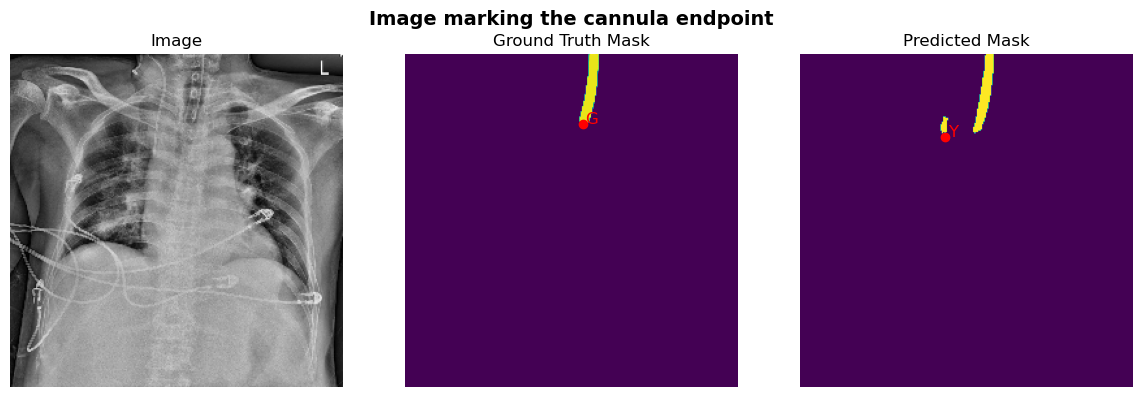

In [26]:
visualize_with_mask_and_endpoints_inline(0)